In [1]:
import visa
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
rm = visa.ResourceManager()

In [3]:
rm.list_resources()

('ASRL1::INSTR', 'ASRL2::INSTR', 'GPIB0::11::INSTR')

In [4]:
sa = rm.open_resource('GPIB0::11::INSTR')

In [5]:
sa.query('ID?')

'HP3561A\r\n'

In [6]:
def get_trace_data():
    """ get a new power spectrum trace from buffer """
    sa.write('DSTB')
    a = sa.read_raw()
    # a[0:2] # crap
    # a[2:4] # length
    # a[4:806] # all trace data
    even = np.fromstring(a[4:806:2], np.int8) # maximum in 2-3 pnt window
    odd = np.fromstring(a[5:806:2], np.int8) # minimum in 2-3 pnt window
    return (even*256+odd)*0.005 # multiply max by 256(?) add min, 0.005 converts to dB

In [7]:
def byte_to_real(b):
    """ take 8 bytes and convert it to a real number
        as per the instructions in the hp3561a manual """
    by = np.fromstring(b, dtype='uint8')
    bi = np.unpackbits(by)
    sign = bi[0]
    exponent = bi[1:12]
    mantissa = bi[12:]
    
    # help!
    
    # should return real number
    return 0

def get_x_data():
    """ calculate frequency data for """
    sa.write('SET?')
    bsetup = sa.read_raw()

    # frequency span = bsetup[593:601]
    span = byte_to_real(bsetup[593:601])
    # center frequency = bsetup[585:593]
    center = byte_to_real(bsetup[585:593])

    # should return some array of frequency values with length 400
    return 0

In [12]:
sa.write('SET?')
bsetup = sa.read_raw()

In [13]:
center = bsetup[585:593]
span = bsetup[593:601]

In [28]:
center

NameError: name 'center' is not defined

In [14]:
import struct
import binascii

In [57]:
def byte_to_bin(by, order):
    i = int.from_bytes(by, byteorder=order)
    b = '{0:064b}'.format(i)
    return b

def parse_bin(s):
    return int(s[1:], 2) / 2.**(len(s) - 1)

In [72]:
bi = byte_to_bin(center, 'big')
sign = ''.join(str(b) for b in [bi[0]])
exponent = ''.join(str(b) for b in bi[1:12]) # excess-1024 notation (integers from -1024 to 1023)
mantissa = ''.join(str(b) for b in bi[12:])
mantissa = '.'+mantissa
print(int(sign), parse_bin(mantissa), int(exponent, 2))
output = (-1.0)**(int(sign))*parse_bin(mantissa)*2**(int(exponent,2)-1024)
print(output)

0 0.06256147427484393 816
1.520785196163557e-64


The format shown in the first line begins with a single sign bit, which is 0 if the number is positive, and 1 if the number is negative. Next is the exponent. If the exponent is eight bits long, as shown in the diagram, it is in excess-128 notation, so that the smallest exponent value, 00000000, stands for -128, and the largest exponent value, 11111111, stands for 127. Finally, we find the mantissa, which is an unsigned binary fraction.

## noise at wire

In [4]:
def get_trace_data():
    """ get a new power spectrum trace from buffer """
    sa.write('DSTB')
    a = sa.read_raw()
    # a[0:2] # crap
    # a[2:4] # length
    # a[4:806] # all trace data
    even = np.fromstring(a[4:806:2], np.int8) # maximum in 2-3 pnt window
    odd = np.fromstring(a[5:806:2], np.int8) # minimum in 2-3 pnt window
    return (even*256+odd)*0.005 # multiply max by 256(?) add min, 0.005 converts to dB

In [5]:
def get_new_reading(start, span, avg):
    """ get a new power spectrum trace from buffer """
    
    # round start and span to nearest half integer
    start = round(start * 2) / 2
    span = round(span * 2) / 2
    
    sa.write('SF{0:.1f}HZ'.format(start))
    sa.write('SP{0:.1f}HZ'.format(span))
    
    if avg<=1:
        sa.write('AVOF')
    else:
        sa.write('AVRS')
        sa.write('NAVG{0:d}ENT'.format(avg))
        
    sa.write('TRFR') # free range trigger
    
    # wait for reading
    while(True):
        stb = '{0:016b}'.format(sa.stb)
        time.sleep(1.0)
        if (int(stb[11]) and int(stb[15])):
            break
            
    time.sleep(2.0) # wait an additional 2 seconds for things to settle down        
    data = get_trace_data()
    freq = np.linspace(start, start+span, len(data))

    return freq, data

In [18]:
# setup instrument

try:
    sa.close()
except:
    pass
sa = rm.open_resource('GPIB0::11::INSTR')
print(sa.query('ID?'))
sa.write('SNGL')
sa.write('HANN')
sa.write('KEYD')
sa.write('VSFS{0:d}DBV'.format(-50)) # define full scale
sa.write('VSDB{0:d}DBR'.format(10)) # dB/div
time.sleep(1.0)

HP3561A



First checking current noise on working device: vanQver4_UL2

current_amp = 1e7 V/A, all gates at 0V

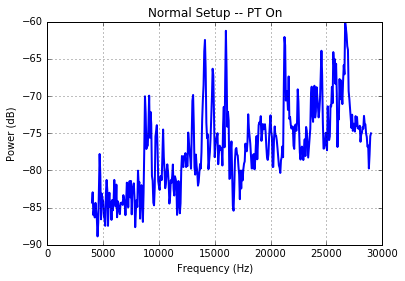

In [53]:
freq, power = get_new_reading(4000, 25000, 10)
fig, ax = plt.subplots(1,1)
ax.plot(freq, power, lw=2)
ax.grid()

ax.set_title('Normal Setup -- PT On')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (dB)')

np.savetxt('normal_setup_pt_on_a.dat', np.stack((freq, power), axis=-1), fmt='%.6e', delimiter=' ', newline='\n')

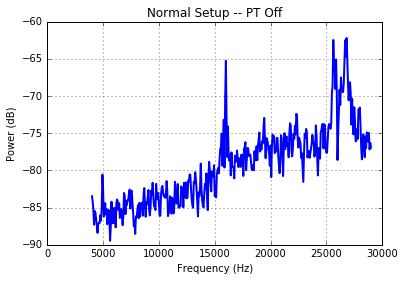

In [54]:
freq, power = get_new_reading(4000, 25000, 10)
fig, ax = plt.subplots(1,1)
ax.plot(freq, power, lw=2)
ax.grid()

ax.set_title('Normal Setup -- PT Off')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (dB)')

np.savetxt('normal_setup_pt_off_a.dat', np.stack((freq, power), axis=-1), fmt='%.6e', delimiter=' ', newline='\n')

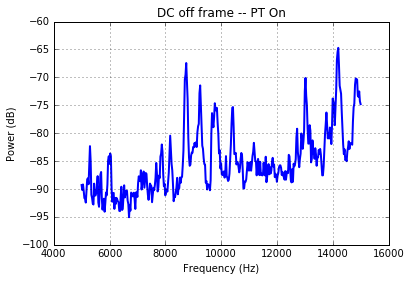

In [16]:
freq, power = get_new_reading(5000, 10000, 25)
fig, ax = plt.subplots(1,1)
ax.plot(freq, power, lw=2)
ax.grid()

ax.set_title('DC off frame -- PT On')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (dB)')

np.savetxt('dc_off_frame_pt_on_e.dat', np.stack((freq, power), axis=-1), fmt='%.6e', delimiter=' ', newline='\n')

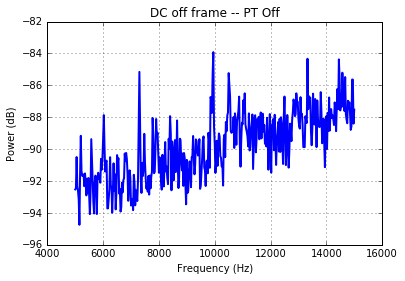

In [17]:
freq, power = get_new_reading(5000, 10000, 25)
fig, ax = plt.subplots(1,1)
ax.plot(freq, power, lw=2)
ax.grid()

ax.set_title('DC off frame -- PT Off')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (dB)')

np.savetxt('dc_off_frame_pt_off_e.dat', np.stack((freq, power), axis=-1), fmt='%.6e', delimiter=' ', newline='\n')

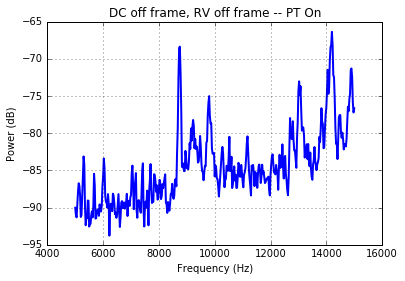

In [19]:
freq, power = get_new_reading(5000, 10000, 25)
fig, ax = plt.subplots(1,1)
ax.plot(freq, power, lw=2)
ax.grid()

ax.set_title('DC off frame, RV off frame -- PT On')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (dB)')

np.savetxt('dc_-rv_off_frame_pt_on_a.dat', np.stack((freq, power), axis=-1), fmt='%.6e', delimiter=' ', newline='\n')

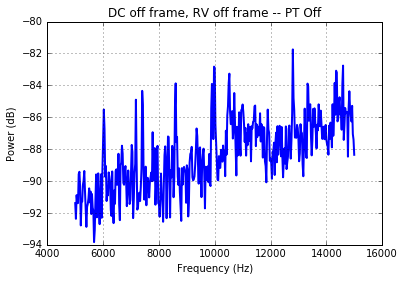

In [20]:
freq, power = get_new_reading(5000, 10000, 25)
fig, ax = plt.subplots(1,1)
ax.plot(freq, power, lw=2)
ax.grid()

ax.set_title('DC off frame, RV off frame -- PT Off')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (dB)')

np.savetxt('dc_-rv_off_frame_pt_off_a.dat', np.stack((freq, power), axis=-1), fmt='%.6e', delimiter=' ', newline='\n')

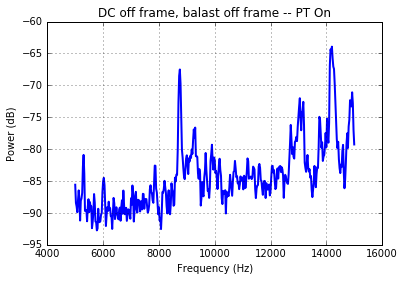

In [21]:
freq, power = get_new_reading(5000, 10000, 25)
fig, ax = plt.subplots(1,1)
ax.plot(freq, power, lw=2)
ax.grid()

ax.set_title('DC off frame, balast off frame -- PT On')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (dB)')

np.savetxt('dc-balast_off_frame_pt_on_a.dat', np.stack((freq, power), axis=-1), fmt='%.6e', delimiter=' ', newline='\n')

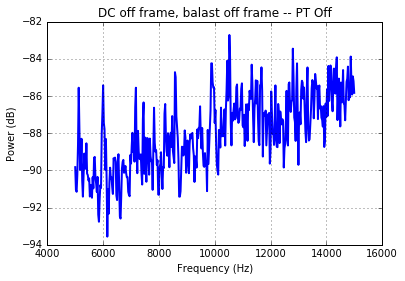

In [22]:
freq, power = get_new_reading(5000, 10000, 25)
fig, ax = plt.subplots(1,1)
ax.plot(freq, power, lw=2)
ax.grid()

ax.set_title('DC off frame, balast off frame -- PT Off')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (dB)')

np.savetxt('dc-balast_off_frame_pt_off_a.dat', np.stack((freq, power), axis=-1), fmt='%.6e', delimiter=' ', newline='\n')

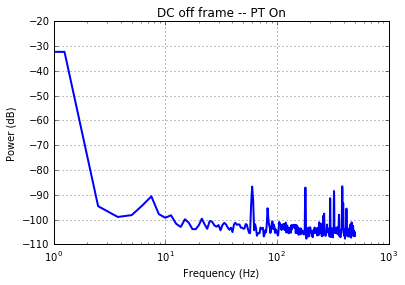

In [23]:
# double checking the low freqency noise with the DC stuff off the frame

freq, power = get_new_reading(0, 500, 25)
fig, ax = plt.subplots(1,1)
ax.plot(freq, power, lw=2)
ax.grid()

ax.set_title('DC off frame -- PT On')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (dB)')

ax.set_xscale('log')

np.savetxt('dc_off_frame_pt_on_aa.dat', np.stack((freq, power), axis=-1), fmt='%.6e', delimiter=' ', newline='\n')

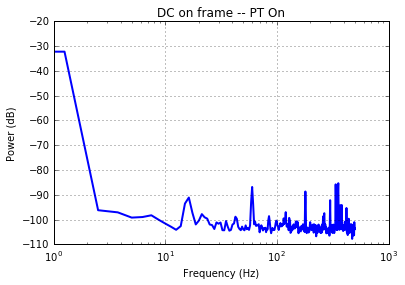

In [27]:
# double checking the low freqency noise with the DC stuff off the frame

freq, power = get_new_reading(0, 500, 25)
fig, ax = plt.subplots(1,1)
ax.plot(freq, power, lw=2)
ax.grid()

ax.set_title('DC on frame -- PT On')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (dB)')

ax.set_xscale('log')

np.savetxt('dc_on_frame_pt_on_cc.dat', np.stack((freq, power), axis=-1), fmt='%.6e', delimiter=' ', newline='\n')